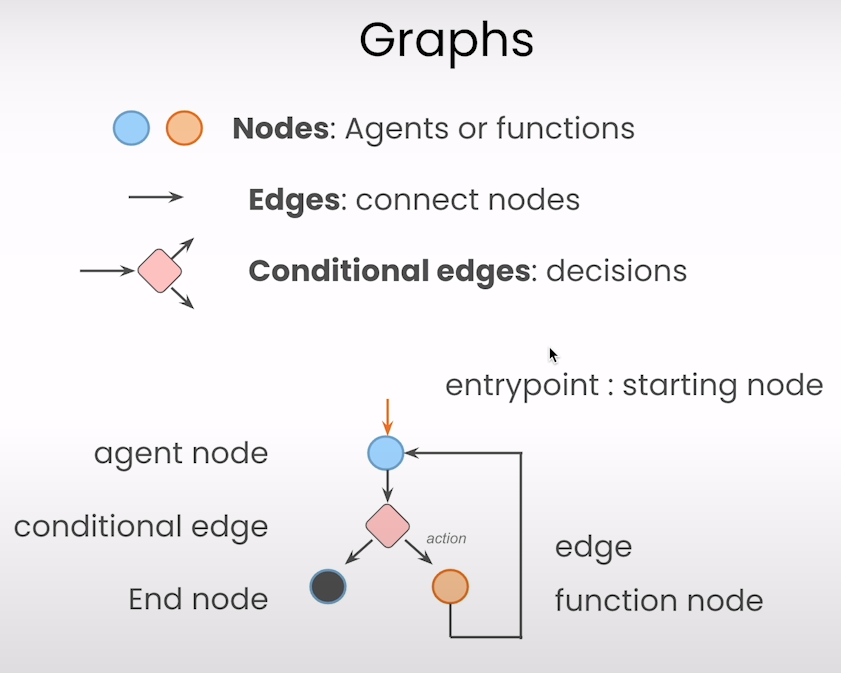

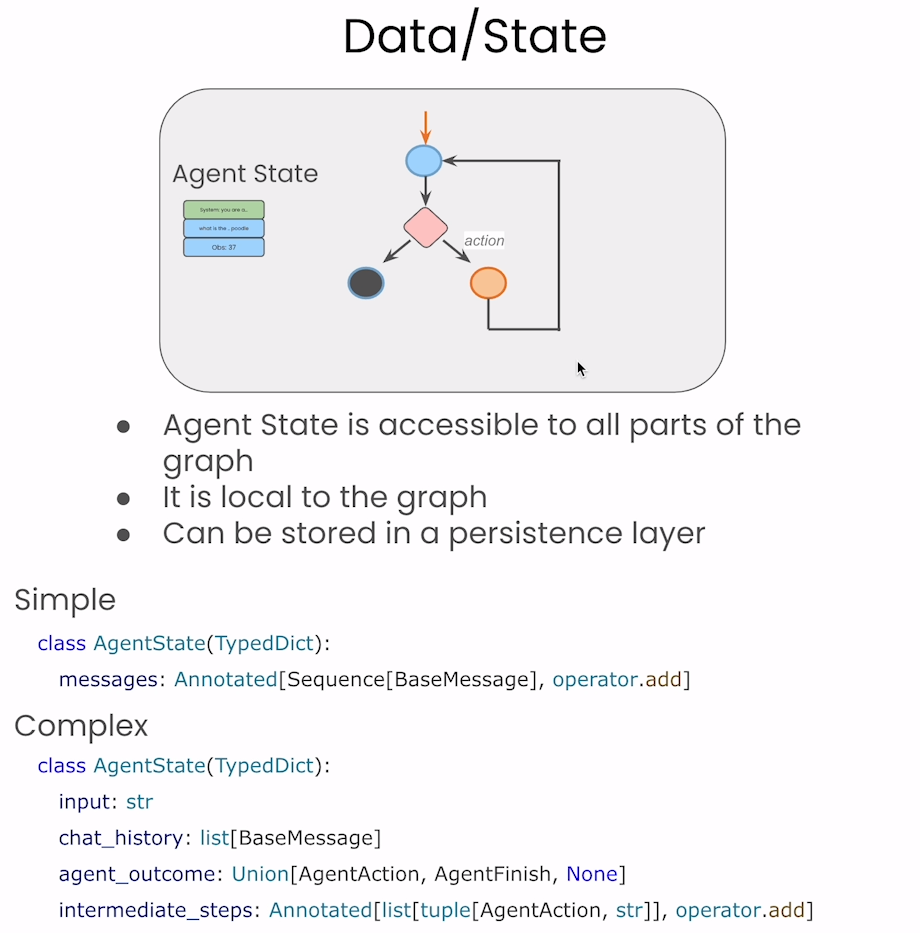

In [2]:
from langchain_groq import ChatGroq
import os, re, getpass
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("GROQ_API_KEY")

model = ChatGroq(temperature=0, model_name="llama3-70b-8192")

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_groq)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_groq(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """
    You are a smart research assistant. Use the search engine to look up information. \
    You are allowed to make multiple calls (either together or in sequence). \
    Only look up information when you are sure of what you want. \
    If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

abot = Agent(model, [tool], system=prompt)

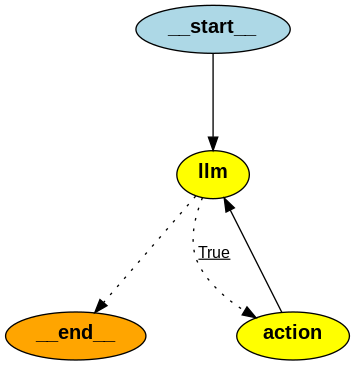

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in san francisco'}, 'id': 'call_81z5'}
Back to the model!


In [9]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_81z5', 'function': {'arguments': '{"query":"current weather in san francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1019, 'total_tokens': 1070, 'completion_time': 0.150999596, 'prompt_time': 0.407519864, 'queue_time': None, 'total_time': 0.5585194600000001}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_87cbfbbc4d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2fd2e28-6fd7-4fbd-8776-e9443507e92a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in san francisco'}, 'id': 'call_81z5'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'la

In [10]:
result['messages'][-1].content

'The current weather in San Francisco is sunny with a temperature of 66.0°F (18.9°C) and a wind speed of 12.5 mph (20.2 km/h).'

In [11]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_sk3f'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_5pk3'}
Back to the model!


In [12]:
result['messages'][-1].content

'The weather in San Francisco is currently sunny with a temperature of 66°F (18.9°C) and humidity of 63%. The wind is blowing at 12.5 mph (20.2 km/h) from the WNW direction.\n\nThe weather in Los Angeles is currently overcast with a temperature of 68°F (20°C) and humidity of 73%. The wind is blowing at 10.5 mph (16.9 km/h) from the WSW direction.'

In [13]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.
query = "Who won the super bowl in 2024? What is the GDP of state where the winning team is located?" 
messages = [HumanMessage(content=query)]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the super bowl in 2024?'}, 'id': 'call_632j'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'What is the GDP of Missouri?'}, 'id': 'call_7ws7'}
Back to the model!


In [14]:
result

{'messages': [HumanMessage(content='Who won the super bowl in 2024? What is the GDP of state where the winning team is located?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_632j', 'function': {'arguments': '{"query":"Who won the super bowl in 2024?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 1035, 'total_tokens': 1119, 'completion_time': 0.245482554, 'prompt_time': 0.466286686, 'queue_time': None, 'total_time': 0.71176924}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0fd143f7-3278-4f7e-a19a-b82b981f0f88-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Who won the super bowl in 2024?'}, 'id': 'call_632j'}]),
  ToolMessage(content='[{\'url\': \'https://www.espn.com/nfl/story/_/id/39480722/49ers-chiefs-live-super-bowl-lviii-updates-moments-highlights\', 

In [15]:
result['messages'][-1].content

'The Kansas City Chiefs won Super Bowl 2024, and the GDP of Missouri, where the Chiefs are located, is approximately $423.6 billion.'